In [3]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
from IPython.display import Markdown,display
import datetime
import time
import re
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import linear_model
from sklearn import preprocessing
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score




asset_directory = "data/data_asset_choosed/487_None"
file_name = "data/data_asset_choosed/487_None/487_51.csv"
df_ride = pd.read_csv(file_name,parse_dates=[1])
df_ride.head(10)

,asset,recorded_at,MDI_OBD_SPEED,GPS_SPEED,MDI_OBD_RPM,MDI_OBD_ENGINE_LOAD,MDI_OBD_FUEL,ODO_FULL_METER,MDI_DASHBOARD_MILEAGE,distance_meter,...,avrg_speed,acceleration,distance_speed,distance_cum,delay,fuel,filled_speed,filled_meter,filled_load,filled_rpm
0,487,2017-10-15 18:49:03,NaN,55992.0,NaN,NaN,3618573.0,5063840.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False
1,487,2017-10-15 18:49:05,105.0,55529.0,2458.0,NaN,3618587.0,NaN,NaN,NaN,...,NaN,NaN,58.333333,58.333333,2.0,NaN,False,False,False,False
2,487,2017-10-15 18:49:06,NaN,55282.0,NaN,NaN,NaN,NaN,NaN,NaN,...,105.000000,NaN,29.166667,87.500000,1.0,NaN,True,False,True,True
3,487,2017-10-15 18:49:08,104.0,55286.0,NaN,NaN,3618601.0,5063952.0,NaN,NaN,...,105.000000,1.0,57.777778,145.277778,2.0,14.0,False,False,True,True
4,487,2017-10-15 18:49:10,105.0,55429.0,2437.0,NaN,3618615.0,NaN,NaN,NaN,...,104.500000,-1.0,58.333333,203.611111,2.0,14.0,False,True,True,False
5,487,2017-10-15 18:49:11,NaN,55337.0,NaN,NaN,NaN,5064064.0,NaN,112.0,...,104.666667,NaN,29.166667,232.777778,1.0,14.0,True,False,True,True
6,487,2017-10-15 18:49:13,106.0,55534.0,NaN,NaN,3618629.0,NaN,NaN,112.0,...,104.666667,-1.0,58.888889,291.666667,2.0,14.0,False,True,True,True
7,487,2017-10-15 18:49:15,NaN,55417.0,2453.0,NaN,3618636.0,NaN,NaN,NaN,...,105.000000,NaN,58.888889,350.555556,2.0,7.0,True,False,True,False
8,487,2017-10-15 18:49:17,105.0,55550.0,NaN,NaN,3618647.0,5064176.0,NaN,112.0,...,105.000000,1.0,58.333333,408.888889,2.0,11.0,False,False,True,True
9,487,2017-10-15 18:49:18,NaN,55660.0,NaN,NaN,NaN,NaN,NaN,112.0,...,105.000000,NaN,29.166667,438.055556,1.0,11.0,True,True,True,True


In [5]:
data = sm.datasets.get_rdataset("dietox", "geepack").data
data.head()

,Weight,Feed,Time,Pig,Evit,Cu,Litter
0,26.50000,NaN,1,4601,1,1,1
1,27.59999,5.200005,2,4601,1,1,1
2,36.50000,17.600000,3,4601,1,1,1
3,40.29999,28.500000,4,4601,1,1,1
4,49.09998,45.200001,5,4601,1,1,1


          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: fuel       
No. Observations: 20898   Method:             REML       
No. Groups:       39      Scale:              0.3545     
Min. group size:  100     Likelihood:         -18946.0044
Max. group size:  3331    Converged:          Yes        
Mean group size:  535.8                                  
---------------------------------------------------------
                Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       0.014    0.108  0.130 0.896 -0.197  0.225
distance_speed  0.438    0.006 74.654 0.000  0.426  0.449
delay           0.300    0.006 49.922 0.000  0.288  0.312
distance_meter  0.063    0.005 13.564 0.000  0.054  0.072
groups RE       0.452    0.175                           



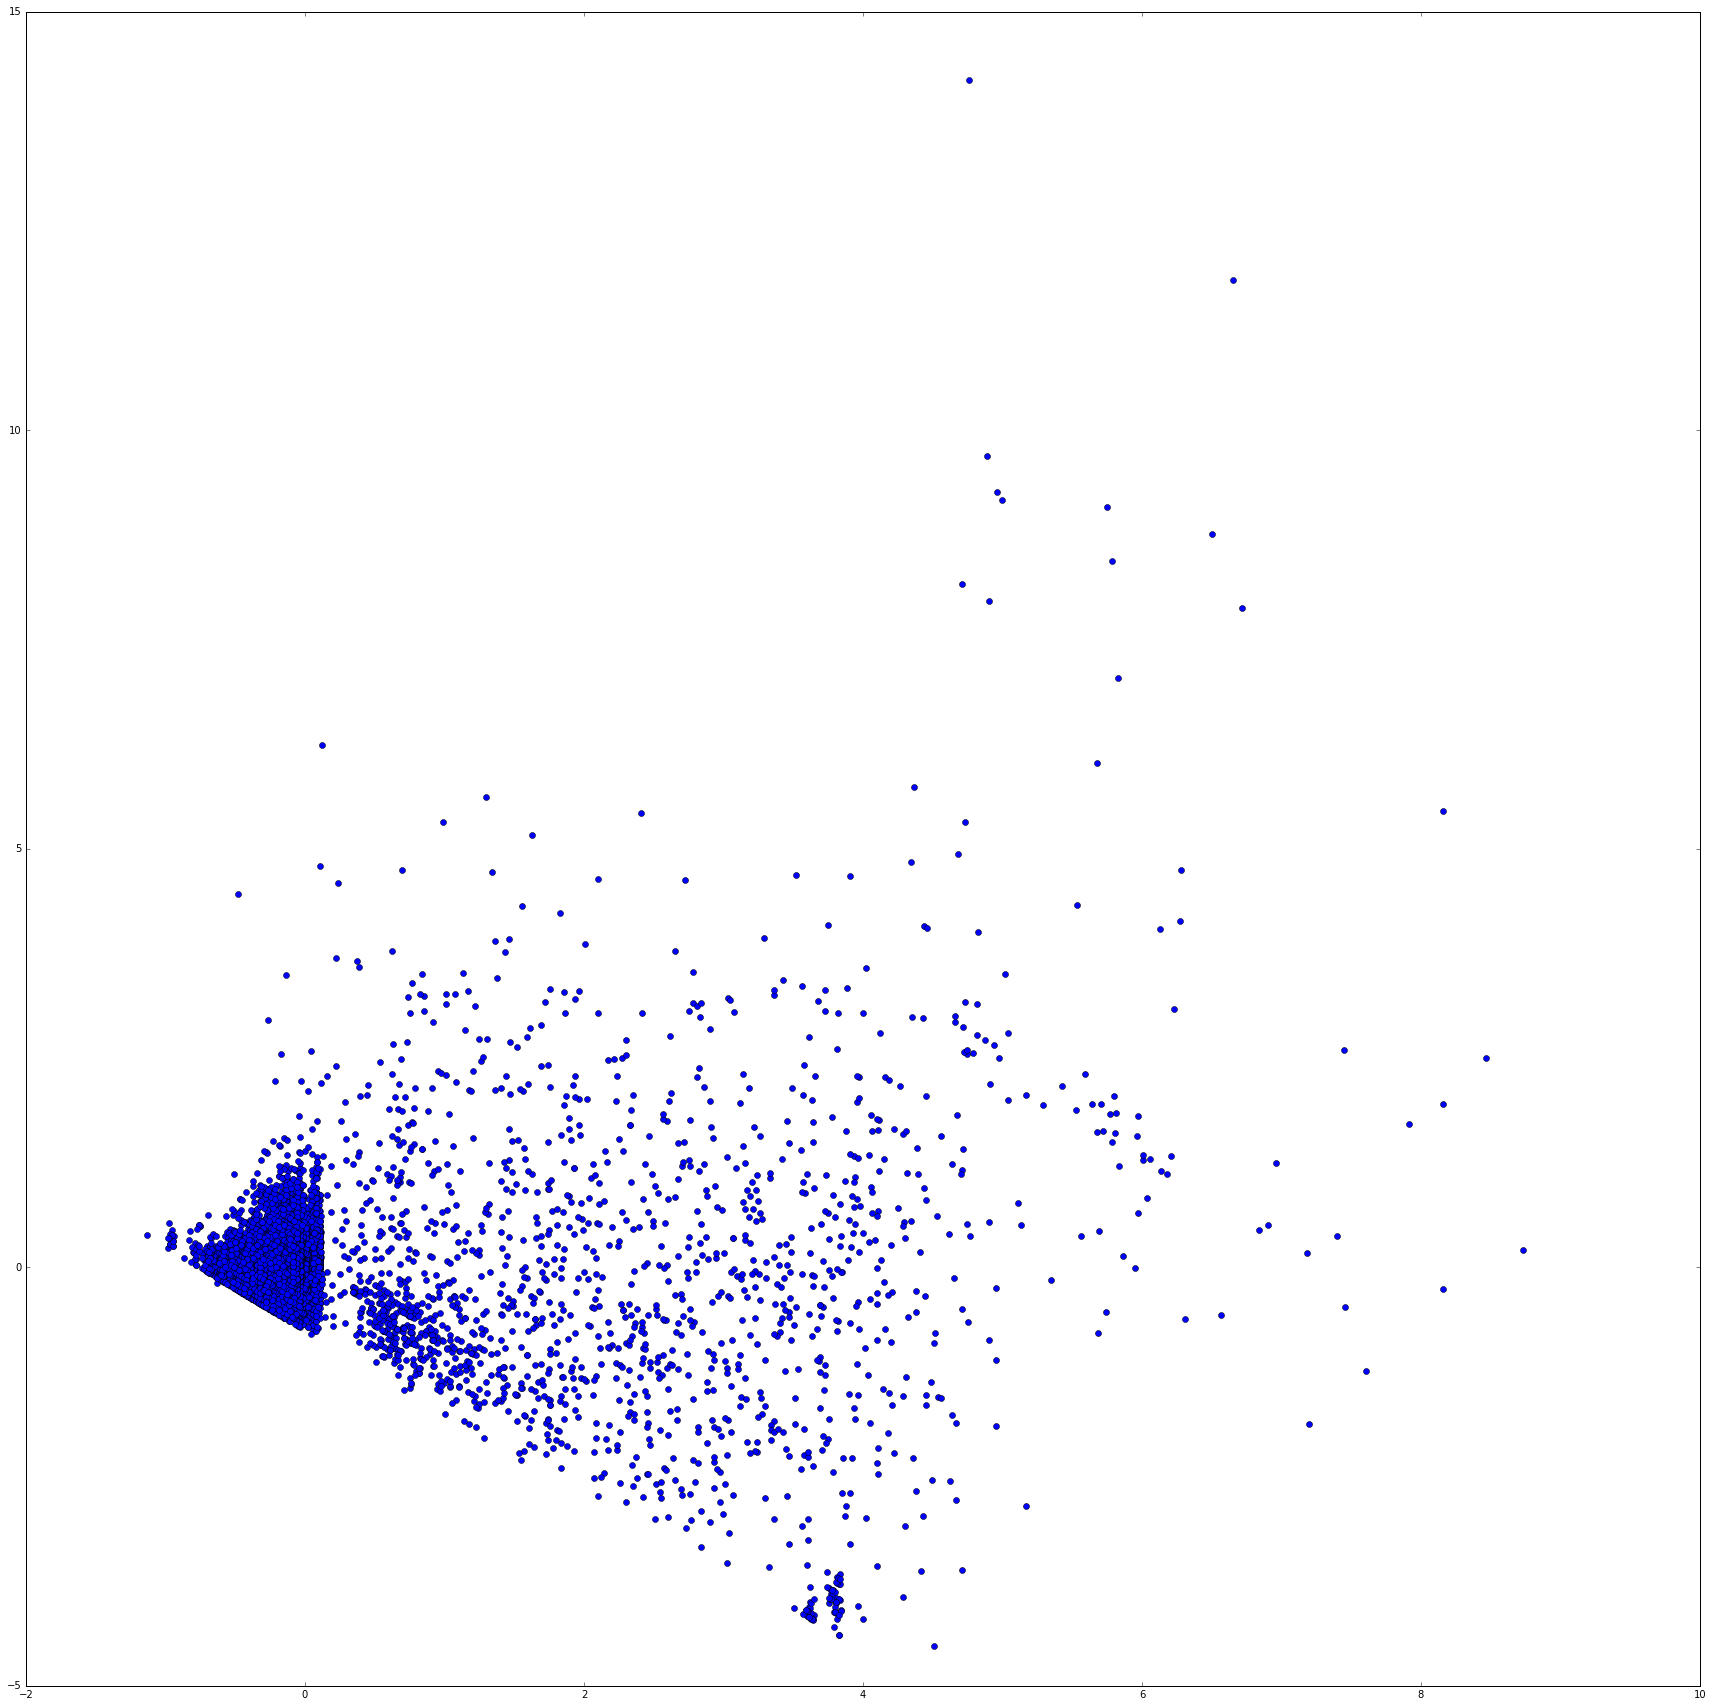

In [50]:
#Statsmodel
#With min max scaling
def min_max_format(df):
    min_max_scaler = preprocessing.StandardScaler()
    df = df[~np.isnan(df['MDI_OBD_FUEL']) & ~np.isnan(df['MDI_OBD_SPEED']) ]
    df= df[~np.isnan(df['fuel']) ]
    df = df[np.isfinite(df['distance_speed'])]
    df = df[np.isfinite(df['distance_meter'])]
    time = df['recorded_at']
    X = pd.DataFrame(min_max_scaler.fit_transform(df[['fuel','distance_speed','delay','distance_meter']]),index=df.index,columns = ['fuel','distance_speed','delay','distance_meter'])
    X['ride'] = df['ride']
    return [X,time]
def merge_sing_asset_col(asset_directory):
    First = True
    for idx,filename in enumerate(os.listdir(asset_directory)):
        name, file_extension = os.path.splitext(asset_directory+"/"+filename)
        if file_extension=='.csv':
            df=pd.read_csv(asset_directory+"/"+filename,parse_dates=[1],na_values=' ')
            if( (len(df)>200) & (len(df[np.isnan(df['MDI_OBD_FUEL'])])/len(df)<0.5) & (len(df[np.isnan(df['MDI_OBD_SPEED'])])/len(df)<0.5)):#Condition: file big enough with enough fuel and distance information
                df['ride'] = pd.Series(np.full(len(df),idx), index=df.index)
                if (First):
                    merged = df
                    First = False
                else:
                    merged = merged.append(df,ignore_index=True)                
    return merged

df_asset = merge_sing_asset_col(asset_directory) 
df_asset.head(10)

data = min_max_format(df_asset)[0]
time = min_max_format(df_asset)[1]
data.head(10)
md = smf.mixedlm("fuel ~ distance_speed + delay + distance_meter ", data, groups=data["ride"])
mdf = md.fit()
print(mdf.summary())
fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(111)

ax.plot(mdf.fittedvalues,mdf.resid, 'o',label="residuals vs fitted")

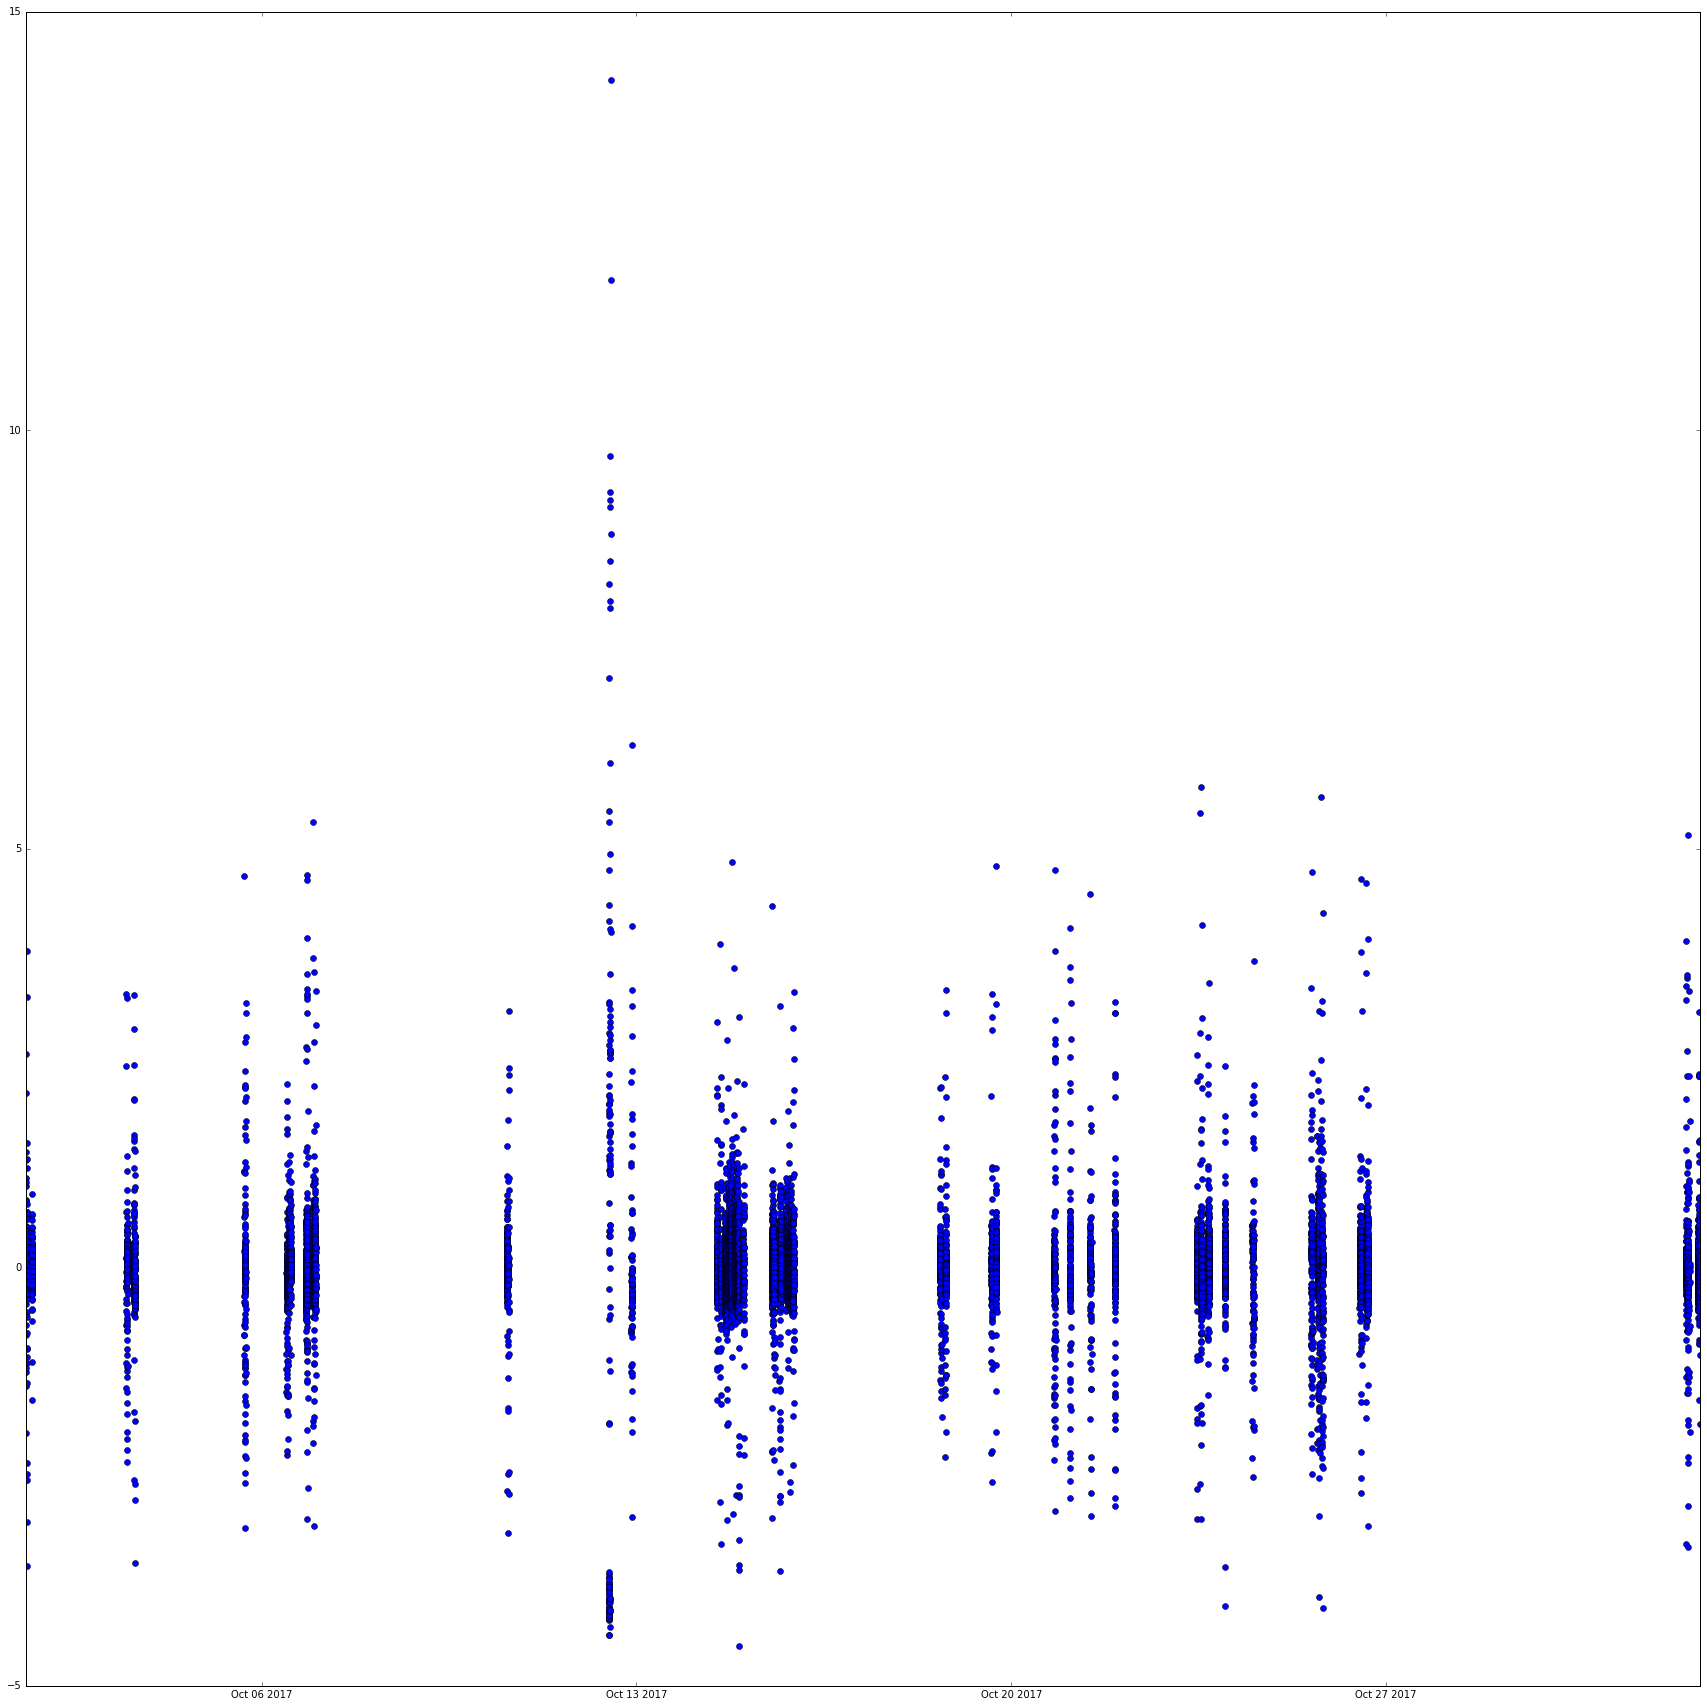

In [49]:
fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(111)

ax.plot(time,mdf.resid, 'o',label="residuals vs fitted")